In [14]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random
from PIL import Image
import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.util import get_normalised_coordinate_grid
from sklearn.model_selection import train_test_split

In [15]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [16]:
device = 'cuda'
num_steps = 100
batch_size = 8512
learn_rate = 0.01
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [17]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [18]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [19]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []

def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
    
        normal = normalize_minus1_to_1(temp_coords)
        normal = torch.nan_to_num(normal, nan = 0)
        if index == 2:
            print(temp_coords)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)
# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

# print(layer1_arragned)
    
    # getting seemingly random output here 
        

tensor([[ 2.,  0.,  3.,  0.],
        [ 2.,  1.,  3.,  0.],
        [ 2.,  2.,  3.,  0.],
        ...,
        [ 2., 61.,  3., 63.],
        [ 2., 62.,  3., 63.],
        [ 2., 63.,  3., 63.]], device='cuda:0')
[[0.0, -1.0, 0.0, -1.0], [0.0, 1.0, 0.0, -1.0], [0.0, -1.0, 0.0, -0.9682539701461792], [0.0, 1.0, 0.0, -0.9682539701461792], [0.0, -1.0, 0.0, -0.9365079402923584], [0.0, 1.0, 0.0, -0.9365079402923584], [0.0, -1.0, 0.0, -0.9047619104385376], [0.0, 1.0, 0.0, -0.9047619104385376], [0.0, -1.0, 0.0, -0.8730158805847168], [0.0, 1.0, 0.0, -0.8730158805847168], [0.0, -1.0, 0.0, -0.841269850730896], [0.0, 1.0, 0.0, -0.841269850730896], [0.0, -1.0, 0.0, -0.8095238208770752], [0.0, 1.0, 0.0, -0.8095238208770752], [0.0, -1.0, 0.0, -0.7777777910232544], [0.0, 1.0, 0.0, -0.7777777910232544], [0.0, -1.0, 0.0, -0.7460317611694336], [0.0, 1.0, 0.0, -0.7460317611694336], [0.0, -1.0, 0.0, -0.7142857313156128], [0.0, 1.0, 0.0, -0.7142857313156128], [0.0, -1.0, 0.0, -0.682539701461792], [0.0, 1.0, 0

#### Set up CPPN_squared

In [20]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

      self.init_weights()
      
    def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              # Initialize weights using Xavier initialization
              init.xavier_normal_(m.weight)
              # Initialize biases to zeros
              init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [21]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [22]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [23]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.6494, 0.2673, 0.3776,  ..., 0.5378, 0.4492, 0.4993], device='cuda:0')


#### Split training and validation set


In [24]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
# train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
# batch_size = int(batch_size * 0.9)

In [25]:
print(normalized_coords_matrix)

tensor([[ 0.0000, -1.0000,  0.0000, -1.0000],
        [ 0.0000,  1.0000,  0.0000, -1.0000],
        [ 0.0000, -1.0000,  0.0000, -0.9683],
        ...,
        [ 0.0000,  0.9365,  0.0000,  1.0000],
        [ 0.0000,  0.9683,  0.0000,  1.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000]], device='cuda:0')


In [27]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

target_im_coords = get_normalised_coordinate_grid(image_shape)
target_im_coords = torch.tensor(target_im_coords, dtype = torch.float32)
target_im = Image.open("ACNMW_ACNMW_DA000182-001.jpg").convert("RGB")
target_im = target_im.resize(image_shape)
target_im_vals = np.reshape(target_im, [-1, num_channels]) / 255
target_im_vals = torch.tensor(target_im_vals, device = device, dtype = torch.float32)


# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, normalized_coords_matrix.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = all_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    # torch.save(CPPN_squared.state_dict(), 'temp_model.pt')

    if i == 0:
        with torch.no_grad():
            fig1, ax1 = plt.subplot()

    if i % 1 == 0:
        with torch.no_grad():
            prediction = CPPN_squared(normalized_coords_matrix)
            prediction = prediction.flatten(0)

            prediction.mul_(2).sub_(1)
            index_tracker = 0
        
            for name, param in cppn1.named_parameters():
                # print(name)
                if name.endswith(".weight"):
                    # print(param) 
                    temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
                    # print(param.numel())
                    temp_tensor = torch.reshape(temp_tensor, param.shape)
                    # print(temp_tensor)
                    param.data.copy_(temp_tensor)
                    # print(param.numel())
                    index_tracker += param.numel()
            
                    # print(f"{name} replacement complete")

            torch.save(cppn1.state_dict(), "CPPNsquaredtest_output.pt")

    new_pred = cppn1(target_im_coords).to(device)

    loss = criterion(new_pred, target_im_vals)
    
    running_loss += loss.item()
    losses.append(loss.item())


    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(CPPN_squared.state_dict(), 'CPPNsquaredtestbest.pt')
    print(f'step {i}, loss {running_loss:.3f}')
    # wandb.log({"loss": loss.item()})
    running_loss = 0.0

            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.036
step 1, loss 0.036
step 2, loss 0.036
step 3, loss 0.036
step 4, loss 0.036
step 5, loss 0.036
step 6, loss 0.036
step 7, loss 0.036
step 8, loss 0.036
step 9, loss 0.036
step 10, loss 0.036
step 11, loss 0.036
step 12, loss 0.036
step 13, loss 0.036
step 14, loss 0.036
step 15, loss 0.036
step 16, loss 0.036
step 17, loss 0.036
step 18, loss 0.036
step 19, loss 0.036
step 20, loss 0.036
step 21, loss 0.036
step 22, loss 0.036
step 23, loss 0.036
step 24, loss 0.036
step 25, loss 0.036
step 26, loss 0.036
step 27, loss 0.036
step 28, loss 0.036
step 29, loss 0.036
step 30, loss 0.036
step 31, loss 0.036
step 32, loss 0.036
step 33, loss 0.036
step 34, loss 0.036
step 35, loss 0.036
step 36, loss 0.036
step 37, loss 0.036
step 38, loss 0.036
step 39, loss 0.036
step 40, loss 0.036
step 41, loss 0.036
step 42, loss 0.036
step 43, loss 0.036
step 44, loss 0.036
step 45, loss 0.036
step 46, loss 0.036
step 47, loss 0.036
step 48, loss 0.036
step 49, loss 0.036
step 50, l

In [28]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([-3.1771e-01,  1.8642e-03, -3.1104e-01,  3.8058e-03, -3.0436e-01,
         5.8693e-03, -2.9767e-01,  8.0553e-03, -2.9099e-01,  1.0363e-02,
        -2.8430e-01,  1.2793e-02, -2.7762e-01,  1.5345e-02, -2.7095e-01,
         1.8019e-02, -2.6429e-01,  2.0814e-02, -2.5764e-01,  2.3731e-02,
        -2.5101e-01,  2.6768e-02, -2.4441e-01,  2.9925e-02, -2.3783e-01,
         3.3201e-02, -2.3128e-01,  3.6596e-02, -2.2476e-01,  4.0109e-02,
        -2.1828e-01,  4.3739e-02, -2.1184e-01,  4.7485e-02, -2.0544e-01,
         5.1346e-02, -1.9909e-01,  5.5321e-02, -1.9278e-01,  5.9408e-02,
        -1.8653e-01,  6.3606e-02, -1.8033e-01,  6.7914e-02, -1.7420e-01,
         7.2331e-02, -1.6812e-01,  7.6854e-02, -1.6210e-01,  8.1482e-02,
        -1.5616e-01,  8.6213e-02, -1.5028e-01,  9.1046e-02, -1.4448e-01,
         9.5978e-02, -1.3875e-01,  1.0101e-01, -1.3311e-01,  1.0613e-01,
        -1.2754e-01,  1.1135e-01, -1.2206e-01,  1.1666e-01, -1.1666e-01,
         1.2206e-01, -1.1135e-01,  1.2754e-01, -1.0

In [29]:
print(all_pixel_values)

tensor([0.6494, 0.2673, 0.3776, 0.2618, 0.3889, 0.4289, 0.3819, 0.8312, 0.5744,
        0.2468, 0.5277, 0.2417, 0.7234, 0.3875, 0.6201, 0.7878, 0.3141, 0.3277,
        0.5672, 0.4687, 0.7958, 0.2176, 0.6637, 0.7691, 0.4550, 0.1616, 0.4223,
        0.6780, 0.1552, 0.7048, 0.7241, 0.6180, 0.5979, 0.1735, 0.3758, 0.6905,
        0.2500, 0.2031, 0.7624, 0.8321, 0.3883, 0.3330, 0.6993, 0.8416, 0.4086,
        0.3928, 0.7065, 0.4112, 0.2037, 0.7297, 0.3063, 0.8517, 0.7382, 0.2394,
        0.8205, 0.7929, 0.3778, 0.3466, 0.3069, 0.7443, 0.7961, 0.8212, 0.6268,
        0.7238, 0.8099, 0.1766, 0.5919, 0.4960, 0.3490, 0.3832, 0.4607, 0.5287,
        0.6266, 0.5209, 0.4832, 0.5696, 0.2973, 0.3054, 0.8517, 0.6940, 0.2149,
        0.3838, 0.2859, 0.7843, 0.3928, 0.4710, 0.3689, 0.7761, 0.6670, 0.8319,
        0.7253, 0.6910, 0.4381, 0.5713, 0.7184, 0.2563, 0.2589, 0.4412, 0.2775,
        0.3859, 0.2547, 0.7255, 0.4307, 0.6951, 0.5775, 0.7000, 0.3230, 0.2996,
        0.2145, 0.6745, 0.5687, 0.2909, 

Text(0.5, 1.0, 'target')

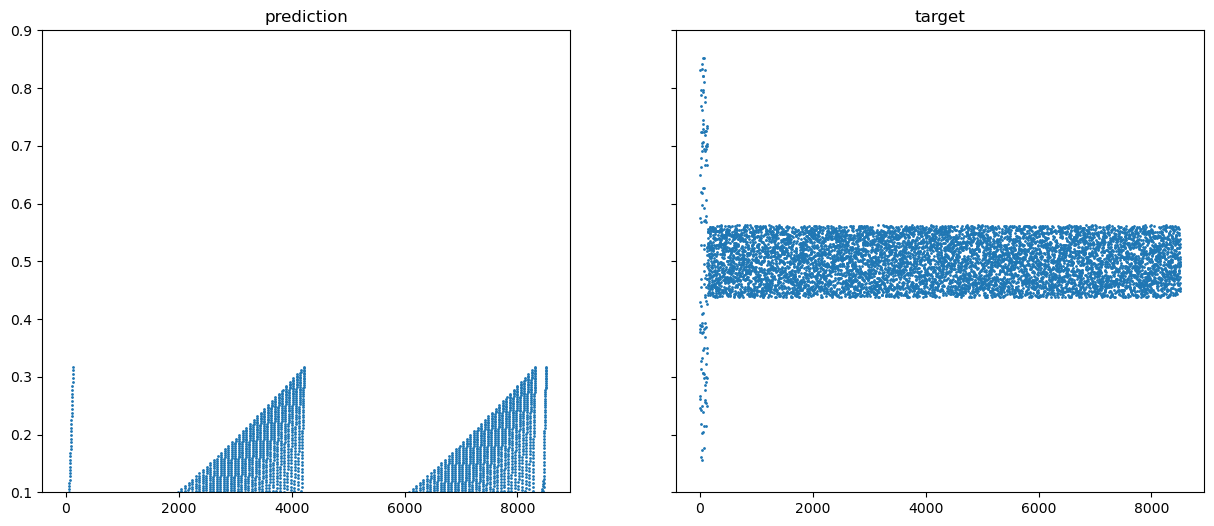

In [30]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))


ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [31]:
prediction.mul_(2).sub_(1)
index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "CPPNsquared_output.pt")

128
tensor([[-1.6354, -0.9963],
        [-1.6221, -0.9924],
        [-1.6087, -0.9883],
        [-1.5953, -0.9839],
        [-1.5820, -0.9793],
        [-1.5686, -0.9744],
        [-1.5552, -0.9693],
        [-1.5419, -0.9640],
        [-1.5286, -0.9584],
        [-1.5153, -0.9525],
        [-1.5020, -0.9465],
        [-1.4888, -0.9402],
        [-1.4757, -0.9336],
        [-1.4626, -0.9268],
        [-1.4495, -0.9198],
        [-1.4366, -0.9125],
        [-1.4237, -0.9050],
        [-1.4109, -0.8973],
        [-1.3982, -0.8894],
        [-1.3856, -0.8812],
        [-1.3731, -0.8728],
        [-1.3607, -0.8642],
        [-1.3484, -0.8553],
        [-1.3362, -0.8463],
        [-1.3242, -0.8370],
        [-1.3123, -0.8276],
        [-1.3006, -0.8179],
        [-1.2890, -0.8080],
        [-1.2775, -0.7980],
        [-1.2662, -0.7877],
        [-1.2551, -0.7773],
        [-1.2441, -0.7667],
        [-1.2333, -0.7559],
        [-1.2227, -0.7449],
        [-1.2123, -0.7338],
        [-1.2020